<a href="https://colab.research.google.com/github/arizonaCameraLab/computationalImaging/blob/master/Chapter5WaveImaging/diffuserImaging.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Coherent imaging through a diffuser
## David Brady
## University of Arizona
## September 2023 and November 2024

# System analysis





We consider the transformation between an input distribution $f(x)$ and an output distribution $g(x)$ under the Fresnel transformation. The Fresnel transormation is defined as
$${\tilde f}_\tau (x)=\frac{1}{\tau}\int_{-\infty}^{\infty} f(x')e^{i\pi \frac{(x-x')^2}{\tau^2}} dx'$$
The Gaussian distribution $\phi_o(x)=e^{-\pi \frac{x^2}{w^2}}$ is an eigenfunction of the Fresnel transformation, specifically
$${\tilde \phi}_\tau (x)= \frac{e^{i\frac{\pi}{4}}}{\sqrt{w^2 +i\tau^2}}e^{-\pi \frac{x^2}{w^2+i\tau^2}}$$

The Fresnel transformation is often used to model wave diffraction. For the input wavefront $f(x)$ the output wave on a boundary a distance $z$ from the input boundary is $g(x)={\tilde f}_{\tau = \sqrt{\lambda z}}(x)$, e.g.
$$g(x)=\frac{1}{\sqrt{\lambda z}} \int_{-\infty}^{\infty} f(x')e^{i\pi \frac{(x-x')^2}{\lambda z}} dx' $$

Of course, one expects that diffracting from plane 0 to plane $z_1$ and then diffracting from plane $z_1$ to plane $z_2$ should produce the same field as diffracting from plane $z=0$ to plane $z_3=z_1+z_2$. For this to occur, one necessarily expects that
$${\tilde {\cal F}}_\tau \left \lbrace f(x) \right \rbrace = {\tilde {\cal F}}_{\sqrt{\tau^2-t^2}} \left \lbrace {\tilde {\cal F}}_t \left \lbrace f(x) \right \rbrace \right \rbrace$$
for $t<\tau$, where ${\tilde {\cal F}}_\tau \left \lbrace \cdot \right \rbrace $ is the Fresnel transform with parameter $\tau$.

#### libraries

In [1]:

import os
import cv2
import numpy as np
import skimage
import scipy
from scipy.interpolate import interp1d
import matplotlib.pyplot as plt
#from google.colab import files
plt.rcParams.update({'font.size': 22})





### Definition of the Fresnel transform and the Guassian beam

In [2]:

def fT(f,dx,tau):
#
# calculate the fresnel transform for 1D signal f with sampling pitch dx.
#
  #u=np.linspace(-1./(2*dx),1./(2*dx),len(f))
  u=np.arange(0,len(f))-len(f)/2
  u=u/np.max(u)
  u=u/(2*dx)
  fT=np.fft.ifft(np.fft.fft(f)*np.fft.fftshift(np.exp(-1j*np.pi*(tau**2)*(u**2) )))
  return fT
def gB(x,tau):
  ## gaussian beam propagated distance tau
  gb=(1/np.sqrt(1+1j*tau**2))*np.exp(-np.pi*(x**2)/(1+1j*tau**2))
  return gb









## Comparison of the Fresnel diffracted beam and the gaussian mode.

here we compare the Gaussian beam propagated a distance propagation distance z with the gaussian beam propagated a distannce $z_1<z$  and then Fresnel diffacted a distance $z_2=z-z_1$. This is a check of our codes. We assume here that $\lambda =1$, $z$ and $x$ may be assumed to be in units of $\lambda $. The signals are vertically displaced to allow comparison.

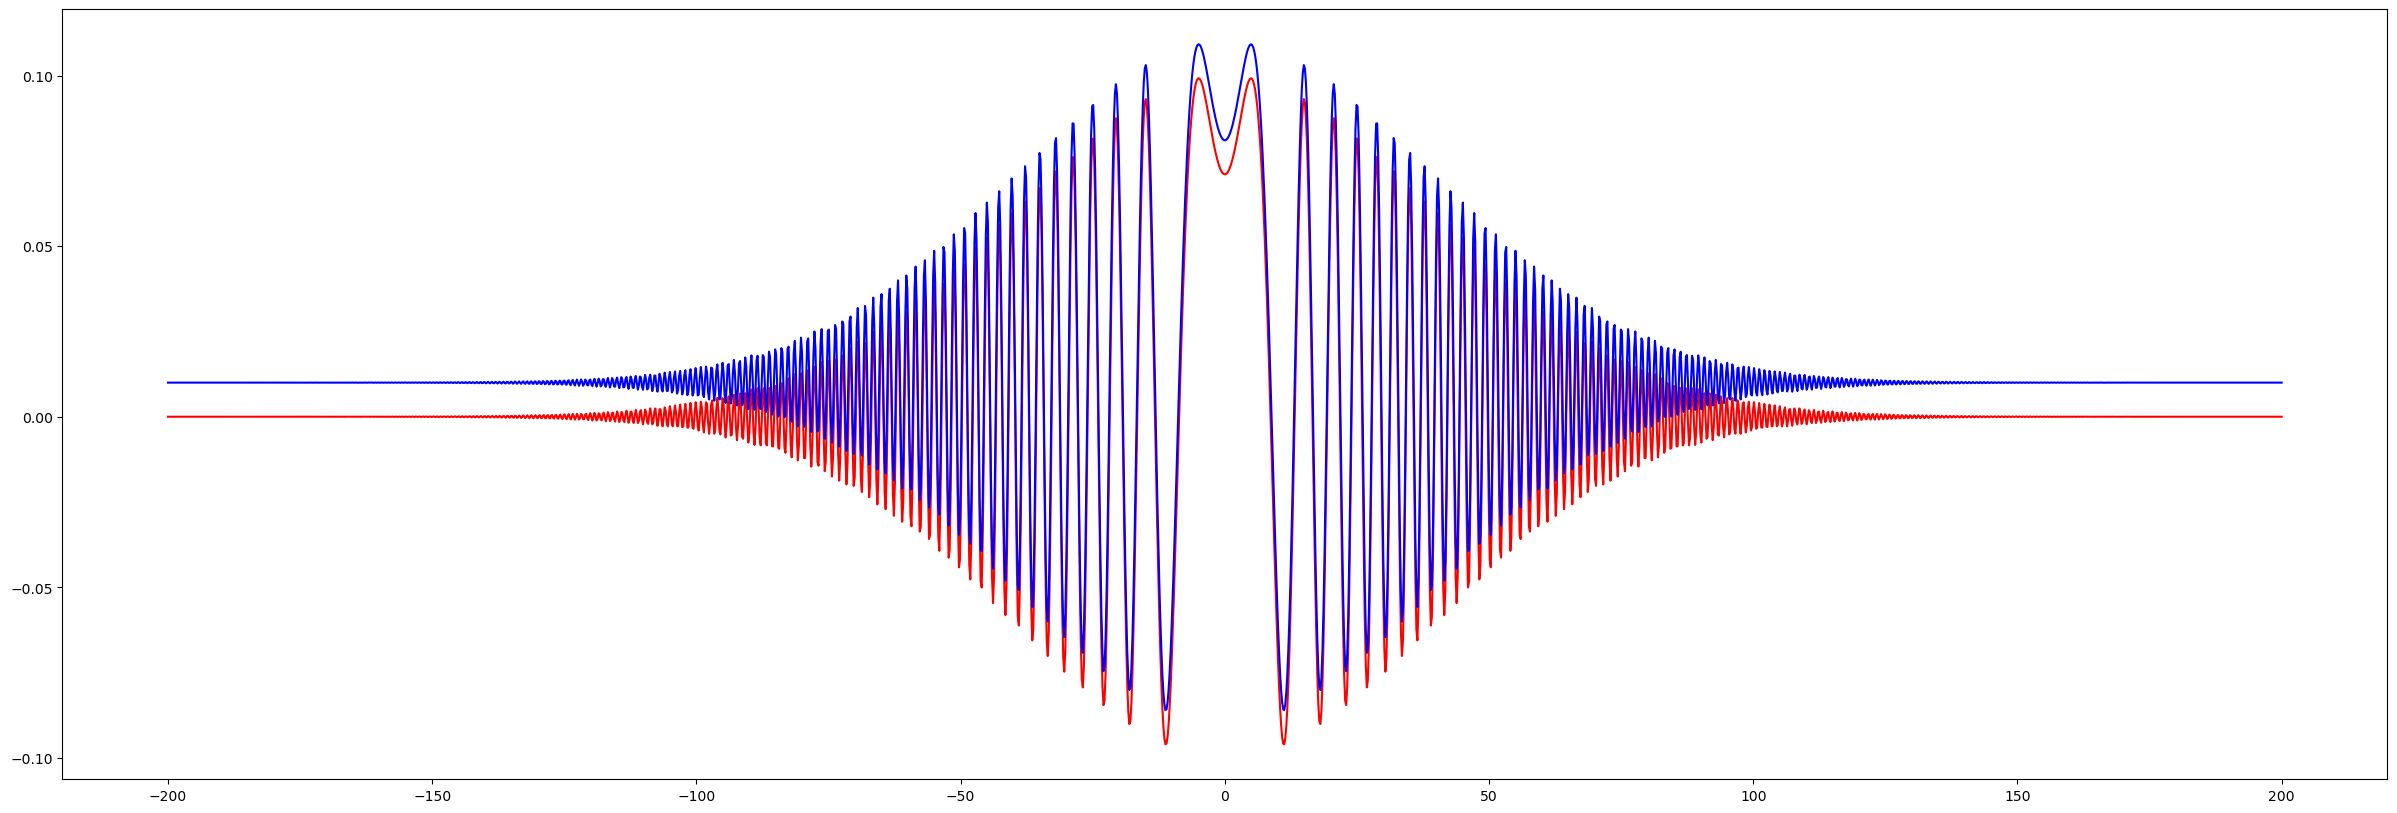

In [ ]:
z=100
z1=60
plt.figure(figsize=(30,10))
x = np.linspace(-200, 200, 2048)
plt.plot(x,np.real(gB(x,np.sqrt(z))),'r',x,np.real(fT(gB(x,np.sqrt(z1)),x[2]-x[1],np.sqrt(z-z1)))+.01,'b')
#plt.plot(x,np.real(fT(fT(gB(x,0),x[2]-x[1],8),x[2]-x[1],6)),'r',x,np.real(fT(gB(x,0),x[2]-x[1],10)),'b')

## Use of SVD to calculate the modes between the input and output planes

The input distribution at $z=o$ is parameterized as by Gaussian beams at positions $x$. We use singular value analysis to find the singular vectors describing the input and output distributions, where both the input and the output are on spaces of extending spanning $-X,X$. Here we let $X=100\lambda$. We create a forward model using an over sampled input space (~5 samples per wavelength). This creates a distrete $\bf H$ matrix describing propagation from the input plane to the output plane. The dicrete form sampled over a finite range avoids issues with aliasing if we were to model this with finite apetures and Fourier analysis.

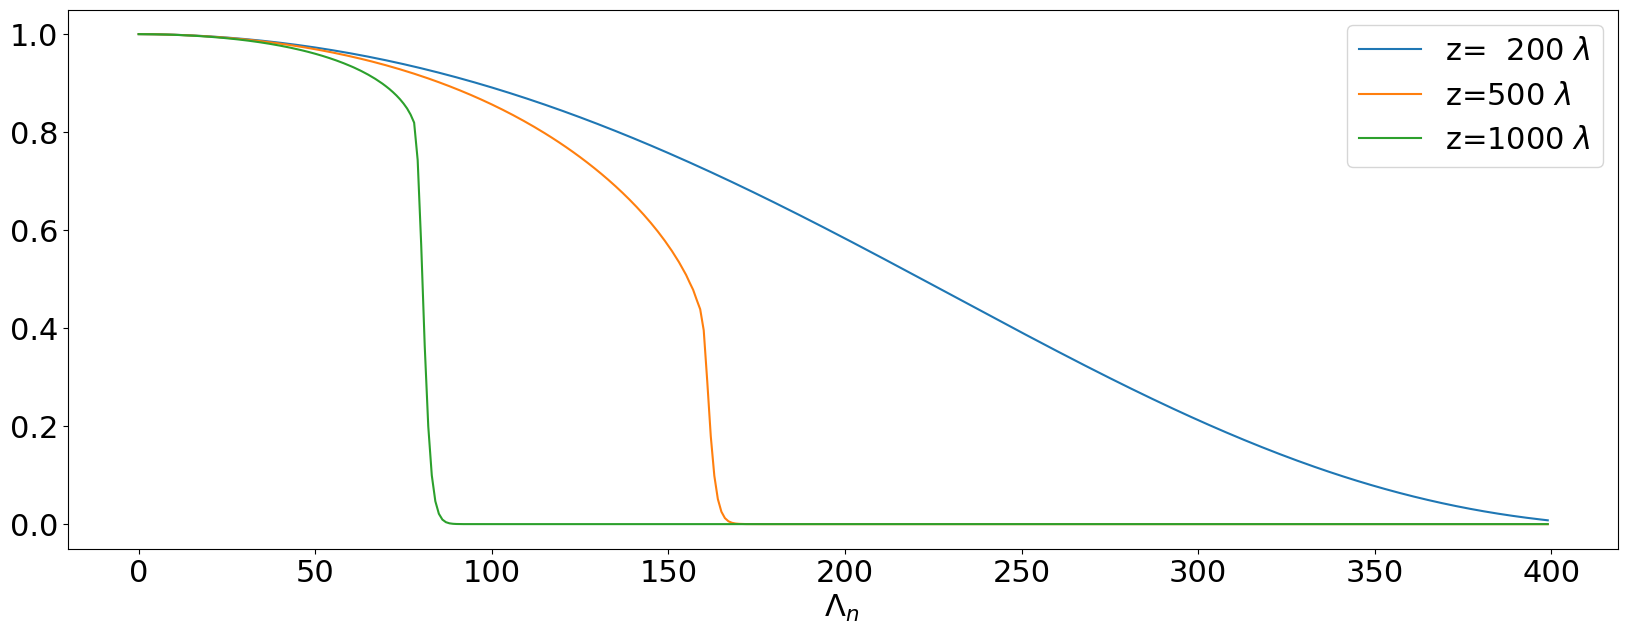

In [6]:
plt.figure(figsize=(20,7))
x = np.linspace(-100, 100, 1024)
xin, xout = np.meshgrid(x, x)
f=np.zeros(1024)
f[500:505]=1
f[510:515]=1
for planeSeparation in [200, 500, 1000]:
  tau=np.sqrt(planeSeparation)
  H=gB(np.sqrt(2)*(xin-xout),tau)
  u, lam, vp=np.linalg.svd(H)
  lb=[r'z=  200 $\lambda$', r'z=500 $\lambda$', r'z=1000 $\lambda$']
  plt.plot(lam[:400]/lam[0])
  lam1000=lam
  plt.xlabel(r"$\Lambda_n$ ")
  plt.legend(lb)
plt.savefig('diffractionModes.pdf')
#files.download('diffractionModes.pdf')



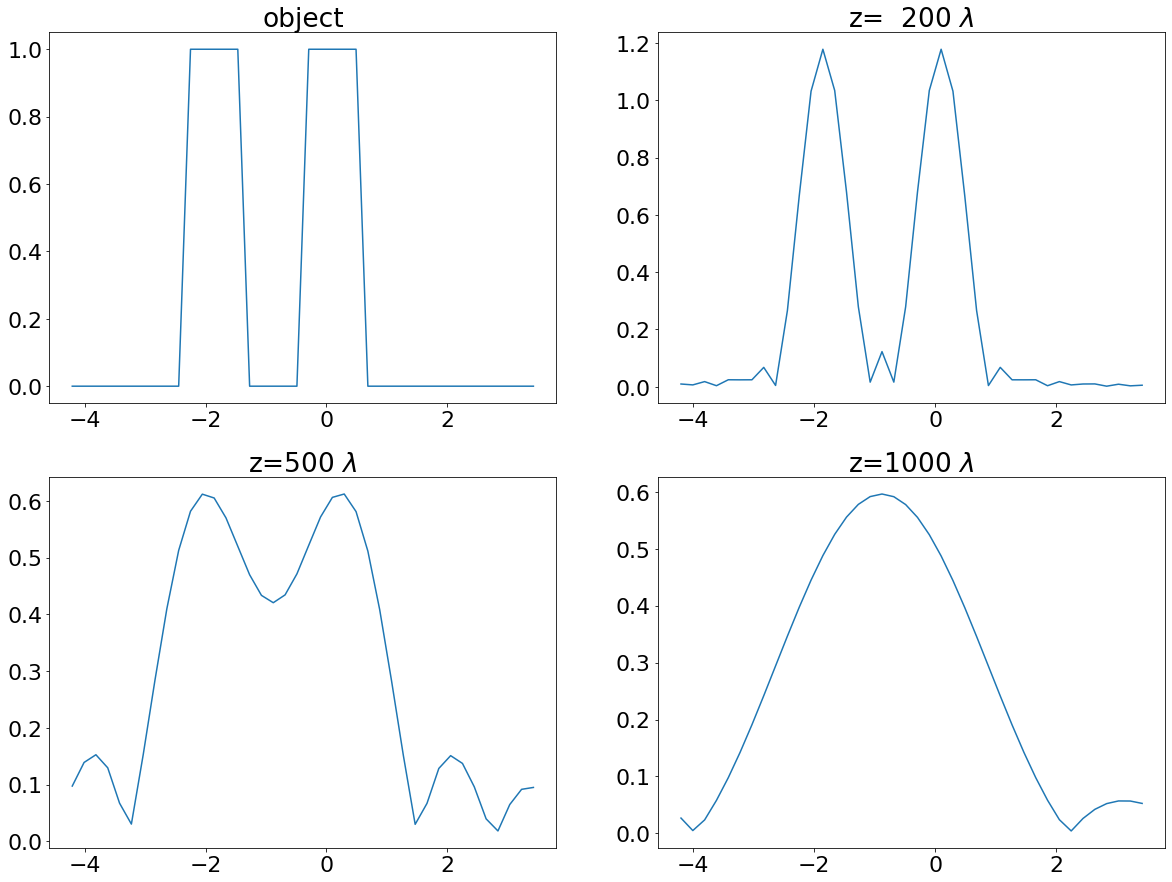

In [ ]:
plt.figure(figsize=(20,15))
x = np.linspace(-100, 100, 1024)
xin, xout = np.meshgrid(x, x)
f=np.zeros(1024)
f[500:505]=1
f[510:515]=1
plt.subplot(2,2,1)
plt.plot(x[490:530],f[490:530])
plt.title('object')
separations=[200, 500, 1000]
titles=[r'z=  200 $\lambda$', r'z=500 $\lambda$', r'z=1000 $\lambda$']
for pip in range(3):
  tau=np.sqrt(separations[pip])
  H=gB(np.sqrt(2)*(xin-xout),tau)
  plt.subplot(2,2,pip+2)
  plt.plot(x[490:530],np.abs(np.linalg.lstsq(H,H@f,rcond=.01)[0])[490:530])
  plt.title(titles[pip])
plt.savefig('ImageBlurProp.pdf')


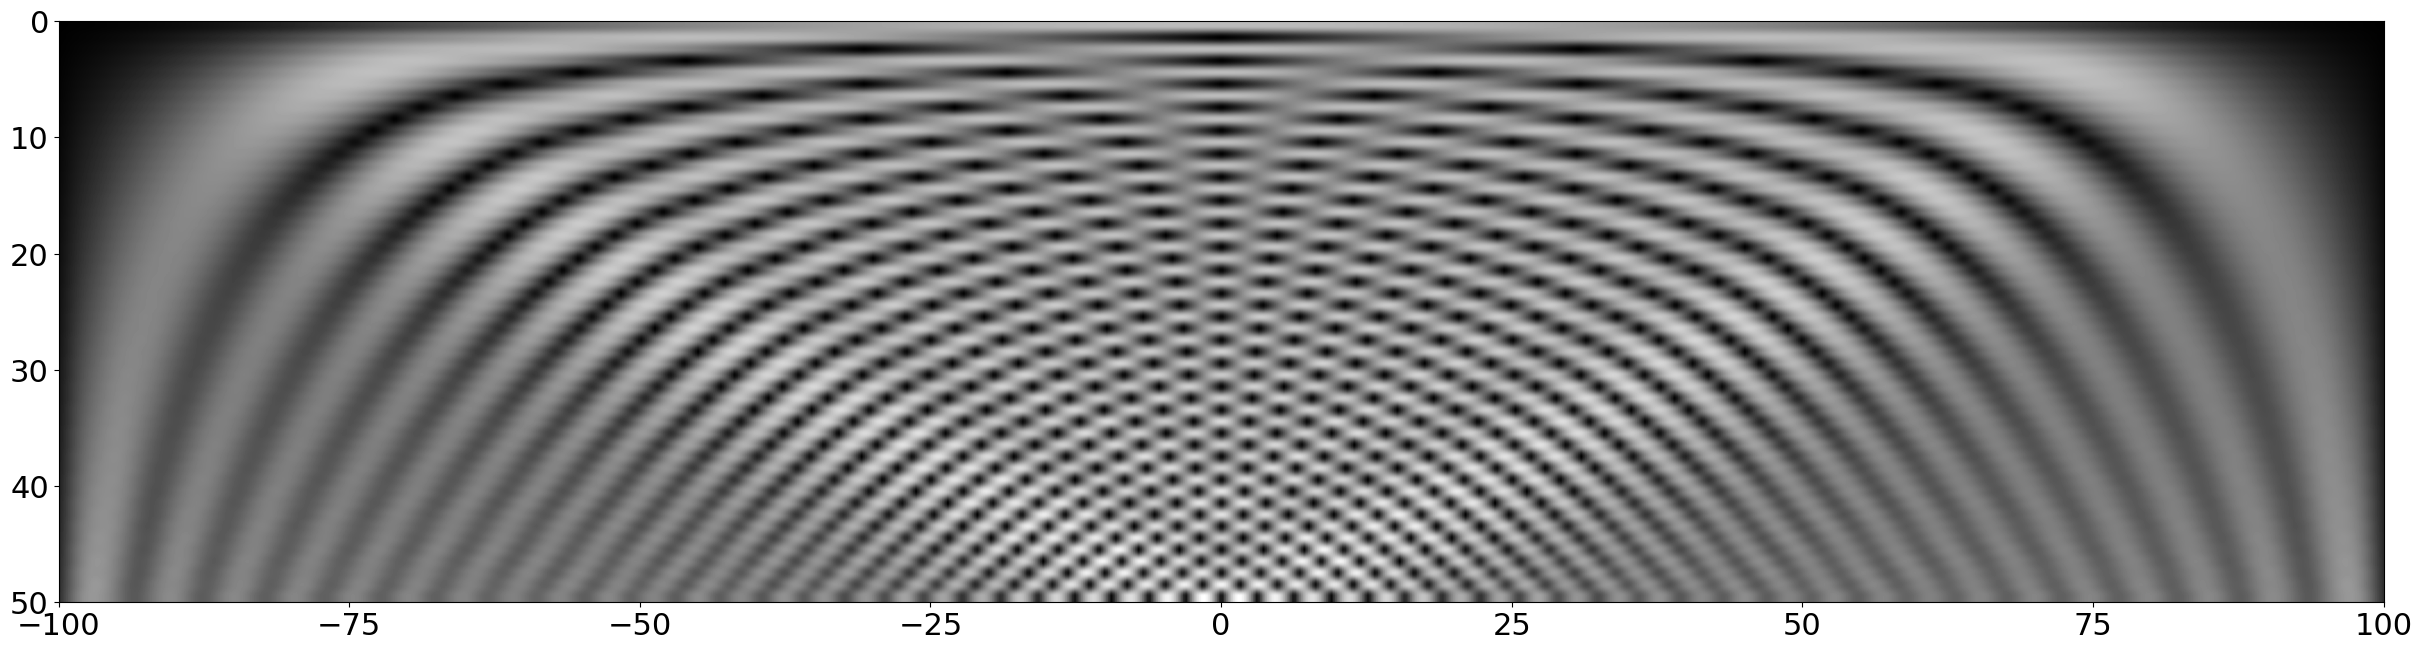

In [8]:
plt.figure(figsize=(30,30))
vp1=vp
plt.imshow(np.abs(vp1[:50,:]), extent=[-100,100,50,0], cmap='gray')
#plt.savefig('diffractionModesObjectSpace.pdf')
#files.download('diffractionModesObjectSpace.pdf')

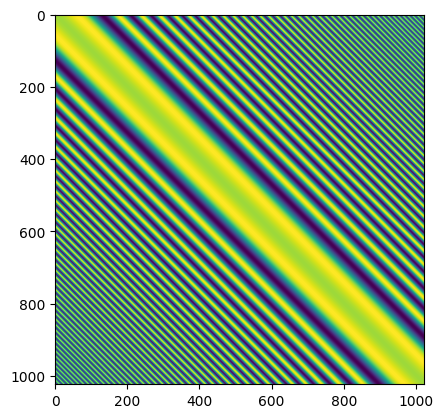

In [ ]:
plt.imshow(np.real(H))

## with a diffuser

here we develop propagation matrices $\bf H$ by the same method as above, but we after propagating a fixed distance we multiply the field by a planar random phase modulation, then propagate again to the output plane. In the example below the distance between the input and the output is $1000\ \lambda$. The distance to the screen from the output varies.

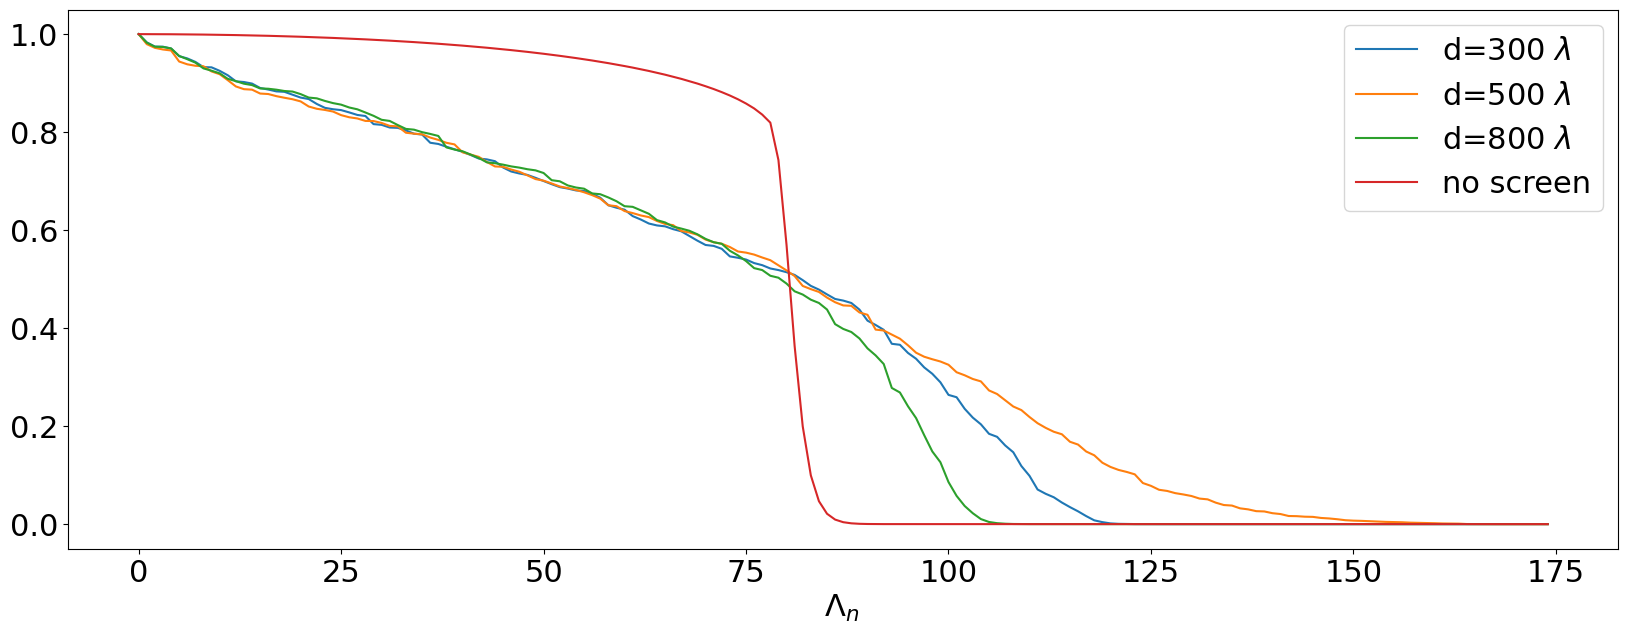

In [4]:
# for each input point
# field at the diffuser
plt.figure(figsize=(20,7))
phase=np.random.random(200)
phaseF=interp1d(np.linspace(-100, 100, 200), phase, kind='cubic')
screenRange=300
Hd=gB(np.sqrt(2)*(xin-xout),np.sqrt(screenRange))@np.diag(np.exp(1j*2*np.pi*phaseF(x)))@gB(np.sqrt(2)*(xin-xout),np.sqrt(1000-screenRange))
u, lam, vp=np.linalg.svd(Hd)
plt.plot(lam[:175]/lam[0], label=r'd=300 $\lambda $')
screenRange=500
Hd=gB(np.sqrt(2)*(xin-xout),np.sqrt(screenRange))@np.diag(np.exp(1j*2*np.pi*phaseF(x)))@gB(np.sqrt(2)*(xin-xout),np.sqrt(1000-screenRange))
u, lam, vp2=np.linalg.svd(Hd)
plt.plot(lam[:175]/lam[0],label='d=500 $\lambda$')
screenRange=800
Hd=gB(np.sqrt(2)*(xin-xout),np.sqrt(screenRange))@np.diag(np.exp(1j*2*np.pi*phaseF(x)))@gB(np.sqrt(2)*(xin-xout),np.sqrt(1000-screenRange))
u, lam, vp=np.linalg.svd(Hd)
plt.plot(lam[:175]/lam[0],label='d=800 $\lambda $')
plt.plot(lam1000[:175]/lam1000[0], label='no screen' )
plt.legend()
plt.xlabel(r"$\Lambda_n$ ")
plt.savefig('diffractionModesDiffuser.pdf')
#files.download('diffractionModesDiffuser.pdf')

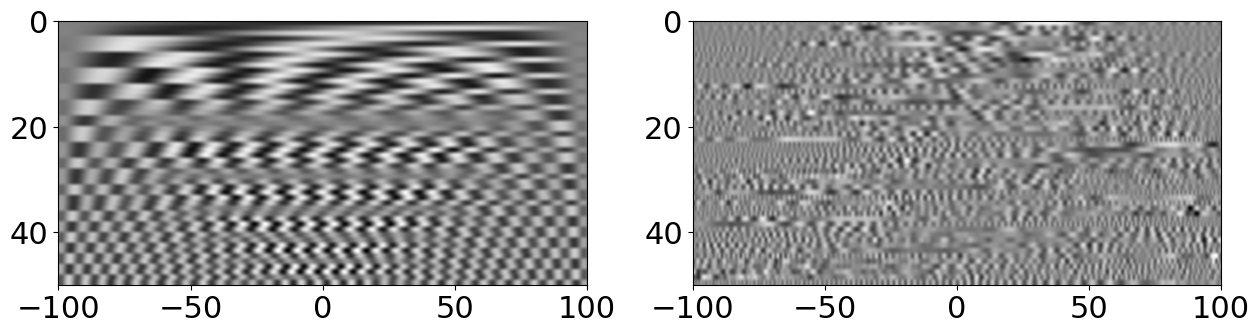

In [9]:
plt.figure(figsize=(15,10))
plt.subplot(1,2,1)
plt.imshow(np.real(vp1[:50,:]), extent=[-100,100,50,0], cmap='gray', aspect=2)
plt.subplot(1,2,2)
plt.imshow(np.real(vp2[:50,:]), cmap='gray', extent=[-100,100,50,0], aspect=2)
plt.savefig('diffractionModesDiffuserSpace.pdf')


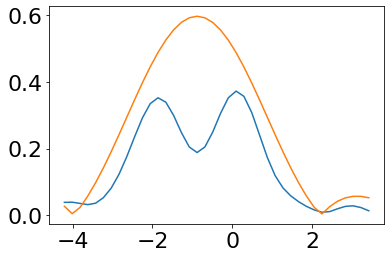

In [ ]:
plt.plot(x[490:530],np.abs(np.linalg.lstsq(Hd,Hd@f,rcond=.01)[0])[490:530])
plt.plot(x[490:530],np.abs(np.linalg.lstsq(H,H@f,rcond=.01)[0])[490:530])
plt.savefig('ImageReconPropDiffuser.pdf')
